# MonkeyType: A Typing Analysis

Author: Daniel Lee

Course Project, UC Irvine, Math 10, S23

## Introduction

The dataset I will analyze is a self-created typing dataset. Using the online typing practice/test platform [MonkeyType](https://monkeytype.com/), I created a dataset of my test runs with varying parameters. I'm able to set one of three main modes: `time` (typing random words within a time limit), `quote` (typing a random quote from a song, book, etc.), and `words` (typing a given number of random words). For `time` and `word`, I can also choose the length of the test (15, 30, 60 seconds and 10, 25, 50 words respectively). Tests with the highest WPM (words per minute) in their respective modes are labeled as a PB (Personal Bests).

In this project, I will analyze the WPM, Consistency, Accuracy, Test Duration, and Mode and their relationship with each other. In addition, I will predict `wpm`, `isPb` (is Personal Best), and `mode` with various machine learning models and assess the accuracy of my model.

## Understanding the Data

Importing the necessary modules:

In [1]:
import pandas as pd
import altair as alt
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import log_loss
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

Loading the data: 
(The columns of the raw data were merged together, so I separated them.)

In [2]:
df_pre = pd.read_csv("monkeytype.csv", sep="|")

Dropping unnecessary columns:

In [3]:
df = df_pre.drop(["_id", "rawWpm", "mode2", "charStats", "quoteLength", "restartCount", "afkDuration", "incompleteTestSeconds", "punctuation", "numbers", "language", "funbox", "difficulty", "lazyMode", "blindMode", "bailedOut", "tags", "timestamp"], axis=1)

Cleaning the `isPb` column:
I filled the `nan` values with `0` and changed all entries as type `int`.

In [4]:
df["isPb"].fillna(0, inplace=True)
df["isPb"] = df["isPb"].astype(int)

This is what our dataframe looks like:

In [5]:
df

,isPb,wpm,acc,consistency,mode,testDuration
0,0,124.00,97.48,86.75,time,15.00
1,0,128.80,100.00,84.24,time,15.00
2,0,128.00,98.77,83.71,time,15.00
3,0,118.58,98.05,85.03,time,60.01
4,0,113.58,96.97,77.44,time,60.01
...,...,...,...,...,...,...
259,0,103.17,98.11,79.31,time,30.01
260,1,106.40,100.00,80.25,time,30.00
261,1,105.56,98.88,78.81,time,30.01
262,1,100.37,95.45,73.69,time,30.01


Some basic statistics to understand the data:

In [6]:
df["mode"].value_counts()

quote    116
time      86
words     62
Name: mode, dtype: int64

The mode I used the most often was `quote` with 116 tests.

In [7]:
df.groupby("mode").mean()

,isPb,wpm,acc,consistency,testDuration
mode,,,,,
quote,0.000000,106.044655,96.696379,73.795259,19.746379
time,0.197674,116.088953,97.797791,81.675465,30.878256
words,0.193548,127.178548,98.290645,78.816129,14.543226


In [8]:
df.groupby("mode").median()

,isPb,wpm,acc,consistency,testDuration
mode,,,,,
quote,0,104.750,97.14,73.480,18.54
time,0,115.960,98.06,81.415,30.01
words,0,125.535,99.05,78.215,12.52


In general, the `words` mode has the highest WPM and Accuracy, while the `time` mode has the highest Consistency and Test Duration.

### Plotting WPM

Here, I plotted Accuracy, Consistency, and Test Duration against WPM individually to understand their relationships.

The following code was implemented from [Bing Chat](https://www.bing.com/search?form=MY02AA&OCID=MY02AA&pl=launch&q=Bing+AI&showconv=1). It uses list comprehension to create a list of charts and concatenates the charts horizontally.
*Documentation of [altair.hconcat](https://altair-viz.github.io/user_guide/generated/toplevel/altair.HConcatChart.html)*

In [9]:
cols = ["acc", "consistency", "testDuration"]

In [10]:
charts = [alt.Chart(df).mark_circle().encode(
    x=alt.X(f"{feature}", scale=alt.Scale(zero=False)),
    y=alt.Y("wpm"),
    color="mode"
).properties(
    width=400,
    height=400,
    title=f"{feature} vs wpm"
) for feature in cols]

alt.hconcat(*charts)

alt.HConcatChart(...)

* There appears to be a positive correlation between Accuracy and WPM. It makes sense that I type faster when I type more accurately. Test runs of the same mode are somewhat clustered together, notably the `words` mode mostly having a 100% Accuracy.
* There appears to be a positive correlation between Consistency and WPM for the `quote` and `time` modes, but no correlation for the `words` mode. It makes sense that I generally type better when my speed is more consistent. The clustering of the data is also more apparent. 
* There appears to be a negative correlation between Test Duration and WPM. It makes sense that the longer the test, the slower I type. The datapoints for the `time` mode create perfect vertical lines because they have a fixed time duration (15, 30, and 60 seconds). Similarly, the `words` mode create a similar pattern to a lesser extent because the number of words of each test is fixed (10, 25, and 50 words). The `quote` mode has varying lengths, so the test duration is not constant.

## Linear Regression for WPM

In this section, I will use linear regression to investigate the relationship between my input features (Accuracy, Consistency, and Test Duration) and the WPM.

Fitting the data to a linear regressor:

In [11]:
reg = LinearRegression()
reg.fit(df[cols], df["wpm"])

LinearRegression()

Finding the coefficients of each input feature:

In [12]:
pd.Series(reg.coef_, index=reg.feature_names_in_)

acc             3.350638
consistency     0.412861
testDuration   -0.212493
dtype: float64

* As predicted by the plots, Accuracy and Consistency have a positive coefficient, while Test Duration has a negative coefficient.
* Accuracy seems to be the strongest predictor of WPM among my input features with the highest absolute value of 3.35.

Assessing the accuracy of my model:

In [13]:
reg.score(df[cols], df["wpm"])

0.5358595755222455

This linear regression yields a 54 percent accuracy. It is certainly better than random guessing, but the performance is admittedly poor.

## Linear Regression with `OneHotEncoder` for WPM

In this section, I will add the input features `mode` and `isPb` to `cols` in hopes for a better result when predicting `wpm`. My features are now both quantitative and discrete, so I will use a `OneHotEncoder` within a `Pipeline`. To transform the data separately, I will also use `ColumnTransformer`. 
*Documentation of [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) and [ColumnTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html)*

In [14]:
cols = ["isPb", "acc", "consistency", "testDuration", "mode"]

Fitting the data to a linear regressor within a Pipeline:
(I used the `passthrough` argument to only onehotencode `isPb` and `mode`.)

In [15]:
pipe = Pipeline([
    ('prep', ColumnTransformer([
        ('enc', OneHotEncoder(), ['isPb', 'mode']),
        ('passthrough', 'passthrough', ['acc', 'consistency', 'testDuration'])
    ])),
    ('reg', LinearRegression())
])

X = df[cols]
y = df['wpm']

pipe.fit(X, y)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('enc', OneHotEncoder(),
                                                  ['isPb', 'mode']),
                                                 ('passthrough', 'passthrough',
                                                  ['acc', 'consistency',
                                                   'testDuration'])])),
                ('reg', LinearRegression())])

Finding the coefficients of each input feature:

In [16]:
pd.Series(pipe["reg"].coef_, index=pipe["prep"].get_feature_names_out())

enc__isPb_0                 -1.436988
enc__isPb_1                  1.436988
enc__mode_quote             -7.164197
enc__mode_time               0.039749
enc__mode_words              7.124447
passthrough__acc             2.558937
passthrough__consistency     0.224498
passthrough__testDuration   -0.207988
dtype: float64

* It makes sense that `enc__isPb_1` has a positive coefficient because PBs should generally have higher WPMs than non-PBs.
* In the beginning, we saw that the `words` mode generally had the highest WPM while the `quote` mode had the lowest. Therefore, it makes sense that the coefficient of `enc__mode_quote` is negative while that of `enc__mode_words` is positive.
* The last three passthrough features (Accuracy, Consistency, and Test Duration) have similar coefficients as the previous linear regression. The coefficients of Accuracy and Consistency is still positive while that of Test Duration is negative.
* The strongest predictor of WPM is now `enc__mode_words`, which makes sense because `words` is my best performing mode. The previous strongest predictor `acc` follows in second.

Assessing the accuracy of my model:

In [17]:
pipe.score(df[cols], df["wpm"])

0.7212414541507111

There is a noticeable improvement in the accuracy of the model, from 53 percent to 72 percent. Adding the features `isPb` and `mode` proved to be beneficial.

## Logistic Regression for `isPb`

In this section, I will use logistic regression to predict whether a test run was a Personal Best.

Removing `mode` and `isPb` and adding `wpm` to my input features:

In [18]:
cols = ["acc", "consistency", "testDuration", "wpm"]

Fitting the data to a logistic regression classifier:

In [19]:
clf = LogisticRegression()
clf.fit(df[cols], df["isPb"])

LogisticRegression()

Finding the coefficients of each input feature:

In [20]:
pd.Series(clf.coef_[0], index=clf.feature_names_in_)

acc             0.955827
consistency    -0.030114
testDuration    0.068597
wpm             0.067818
dtype: float64

* Accuracy is again the strongest predictor of whether a test run will be a personal best.
* Interestingly, Consistency has a negative coefficient while Test Duration has a positive one (the opposite of what we'd assume). This could be because the number of personal bests is quite small compared to the entire dataset (only 11 percent of all tests are PBs). The small magnitude of the coefficients for Consistency and Test Duration likely suggest that there is no meaningful correlation between the two features and `isPb`.
* A particularly surprising result was the small coefficient of WPM. Since Personal Bests are determined by having the highest WPM in a given mode, I expected WPM to have a stronger impact on `isPb`.

Assessing the accuracy of my model:

In [21]:
clf.score(df[cols], df["isPb"])

0.9090909090909091

The logistic regression classifer has a decent 91% accuracy.

## Decision Tree Classifier for `mode`

In this section, I will use a decision tree to predict the `mode` of a test run. I will also use `train_test_split` with a test size of `0.2` to check if my model is underfitting or overfitting.

In [22]:
X_train, X_test, y_train, y_test = train_test_split(df[cols], df["mode"], test_size=0.2, random_state=0)

Fitting the data to a decision tree with `max_leaf_nodes` of `10`:

In [23]:
tree = DecisionTreeClassifier(max_leaf_nodes=10)
tree.fit(X_train, y_train)

DecisionTreeClassifier(max_leaf_nodes=10)

Displaying the decision tree:

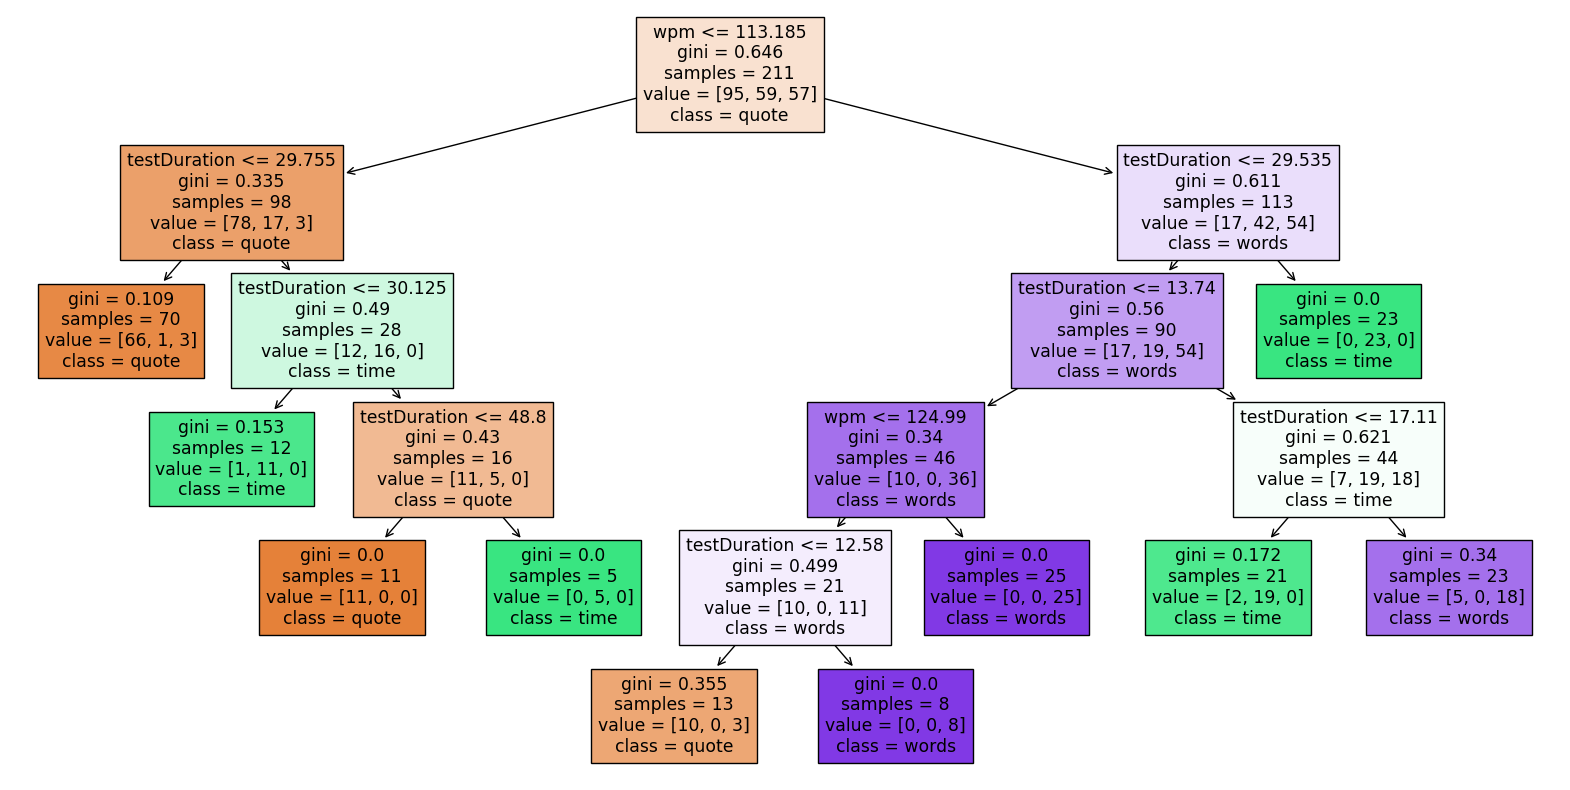

In [24]:
fig = plt.figure(figsize=(20,10))
_ = plot_tree(
    tree, 
    feature_names=tree.feature_names_in_, 
    class_names=tree.classes_, filled=True)

Finding the feature importances:

In [25]:
pd.Series(tree.feature_importances_, index=tree.feature_names_in_)

acc             0.000000
consistency     0.000000
testDuration    0.642597
wpm             0.357403
dtype: float64

* The decision tree does not use Accuracy and Consistency at all. This implies that there is no meaningful correlation between Accuracy & Consistency and Mode.
* The Test Duration is the strongest predictor of the Mode with a feature importance of 0.64. This makes sense since each mode has a very distinct Test Duration (see the `testDuration vs wpm` plot).

Assessing the accuracy of my model for my training and testing datasets:

In [26]:
tree.score(X_train, y_train)

0.9289099526066351

In [27]:
tree.score(X_test, y_test)

0.8867924528301887

The decision tree classifier has a reasonably good accuracy of 93 percent and 89 percent. Although the score for the test data is around 4 percentage points lower than that of the train data, the difference is not too significant. The model is likely not overfitting and there's no need for a Random Forest Classifier.

### Error Curve

Here, I will plot the error curves of my train and test data. First, I will define my error as `1-tree.score(X,y)`.

Creating an empty dataframe with three columns:

In [28]:
df_err1 = pd.DataFrame(columns=["leaves", "error", "set"])

Filling the dataframe:
(I let my number of max leaf nodes vary from 2 to 40.)

In [29]:
for i in range(2,41):
    tree = DecisionTreeClassifier(max_leaf_nodes=i)
    tree.fit(X_train, y_train)
    df_err1.loc[len(df_err1)] = [i, 1-tree.score(X_train, y_train), "train"]
    df_err1.loc[len(df_err1)] = [i, 1-tree.score(X_test, y_test), "test"]  

Plotting the relationship between `leaves` and `error` with `set` as the color to get two lines for the test and train datasets:

In [30]:
alt.Chart(df_err1).mark_line().encode(
    x = "leaves",
    y = "error",
    color = "set",
    tooltip = ["leaves", "error"]
)

alt.Chart(...)

The train curve seems to follow a typical training error curve shape. The test curve on the other hand does not really resemble a U-shape, which is not unusual for real-life data. Both curves seem to have more or less the same error after 25 leaves.

Next, I will repeat the same process but with my error as `log_loss(y,tree.predict_proba(X))`.

In [31]:
df_err2 = pd.DataFrame(columns=["leaves", "error", "set"])
for i in range(2,41):
    tree = DecisionTreeClassifier(max_leaf_nodes=i)
    tree.fit(X_train, y_train)
    df_err2.loc[len(df_err2)] = [i, log_loss(y_train, tree.predict_proba(X_train)), "train"]
    df_err2.loc[len(df_err2)] = [i, log_loss(y_test, tree.predict_proba(X_test)), "test"]  
alt.Chart(df_err2).mark_line().encode(
    x = "leaves",
    y = "error",
    color = "set",
    tooltip = ["leaves", "error"]
)

alt.Chart(...)

The training error curve looks very similar, but the test error curve wildly fluctuates. There is clearly no advantage of using `log_loss` for my dataset.

## Summary

1. Using linear regression to model WPM with Accuracy, Consistency, and Test Duration performed poorly (54% accuracy), but adding the features `isPb` and `mode` noticeably improved the model's accuracy (72% accuracy). Also, Accuracy and the mode being `words` were the strongest predictors of WPM.
2. Using logistic regression to predict `isPb` with Accuracy, Consistency, Test Duration, and WPM performed quite well (91% accuracy). The strongest predictor of `isPb` was again Accuracy.
3. Using a decision tree classifier to predict the `mode` with Accuracy, Consistency, Test Duration, and WPM performed decently (93% and 89% accuracy for train and test data respectively). The small difference in the performance between the train and test data suggests that the model is not overfitting. The strongest predictor of `mode` was the Test Duration.

## References

Source of Dataset: [MonkeyType](https://monkeytype.com/) and Myself
External References: [Bing Chat](https://www.bing.com/search?form=MY02AA&OCID=MY02AA&pl=launch&q=Bing+AI&showconv=1), [altair.hconcat](https://altair-viz.github.io/user_guide/generated/toplevel/altair.HConcatChart.html), [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html), and [ColumnTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=3d55b611-3ab1-43f1-9a99-f081fe2c116b' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>